# Starter Notebook: BCI Competition IV 2b
In 2008, a BCI Competition was held on EEG datasets to find the best ML and statistical algorithms to differentiate different classes of neural data. The BCI Competition IV 2b is a motor imagery dataset with eye artifact data, making it a very realistic dataset. The subjects are prompted to imagine left vs right hand movement and the EEG + EOG signals for each trial are collected. We here have provided a simpler version of the dataset in CSV format for you to get started with. 

This notebook will help you get oriented with processing a single subject's single run, looking at the time and frequency domain in Power Spectral Densities (PSDs). Due to the nature of EEG and it's time-varying properties (i.e. gel dries out, wires move around) and subject-varying properties (i.e. different headset setups, different head and brain folds), it is typically easier to understand a dataset in smaller timeframes, hence starting with a single run. Machine learning + data science methods are typically used to help understand neural data across recordings and subjects. 

Terminology: <br>
- <b>Electroencepholography (EEG)</b>: an electrophysiological monitoring method to record electrical activity of the brain. (Wikipedia) 
- <b>Electrooculography (EOG)</b>: Similar to EEG, but placed around the eyes for the purposes of picking up eye movements and blinks. 
- <b>Power Spectral Densities (PSDs)</b>: A representation of the "amount" of each frequency a signal has.  
- <b>Spectrogram</b>: a visual representation of the spectrum of frequencies of a signal as it varies with time. (Wikipedia)

More details on the experiment can be found here: http://www.bbci.de/competition/iv/desc_2b.pdf  <br>
Data can be downloaded on Kaggles: https://www.kaggle.com/c/ucsd-neural-data-challenge
<br><br>
Search the page for 'Try' to see what you can easily play around with to get a better sense of the data!

## Imports

In [ ]:
import pandas as pd # For working with DataFrames 
import numpy as np # For ease of array manipulation + basic stats
import matplotlib.pyplot as plt # For plotting pretty plots :) 
import scipy.signal as signal # For calculating PSDs and plotting spectrograms
!pip install neurodsp
from neurodsp.spectral import compute_spectrum # for smoothed PSD computation
from pathlib import Path # For making paths compatible on Windows and Macs

     |████████████████████████████████| 88 kB 2.8 MB/s 


## Load Data
Loading compeititon data from Kaggles, custom feature extraction files from Github

*   [Mount Google Drive](https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa) </br>
*   [Structure Colab Project](https://neptune.ai/blog/google-colab-dealing-with-files)
*   [Git LFS](https://stackoverflow.com/questions/54451856/how-can-i-tell-if-a-file-will-begrrectly)
*   [Git Detached Head State](https://www.cloudbees.com/blog/git-detached-head)
*   [Download data from Kaggles on Colab](https://www.kaggle.com/c/ucsd-neural-data-challenge/data)



In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
# path need not to be modified if this folder is in the root directory of the drive
%cd '/content/gdrive/MyDrive/Neural Data Competition'

/content/gdrive/MyDrive/Neural Data Competition


## Constants

In [13]:
eeg_fs = 250 # Data was recorded at 250 Hz

## Helper Functions

In [14]:
## Create DF for each of these, columns are channels, each row is a trial run
def getDF(epochs, labels, times, chans):
    data_dict = {}
    for i, label in enumerate(labels): 
        start_time = times[i][0]
        if 'start_time' not in data_dict: 
            data_dict['start_time'] = list()
        data_dict['start_time'].append(start_time)
        
        if 'event_type' not in data_dict:
            data_dict['event_type'] = list()
        data_dict['event_type'].append(label)
        
        for ch in range(len(chans)): 
            if chans[ch] not in data_dict:
                data_dict[chans[ch]] = list() 
            data_dict[chans[ch]].append(epochs[i][ch])
        
    return pd.DataFrame(data_dict)

In [15]:
# Extract data from raw dataframes for constructing trial-by-trial dataframe
def getEpochedDF(eeg_df, event_df, trial_duration_ms=4000):
    epochs = []
    epoch_times = []
    labels = []
    start_df = eeg_df[eeg_df['EventStart'] == 1]
    for i, event_type in enumerate(event_df["EventType"].values): 
        labels.append(event_type)
        start_time = start_df.iloc[i]["time"]
        end_time = int(start_time + trial_duration_ms)
        epoch_times.append((start_time, end_time))
        sub_df = eeg_df[(eeg_df['time'] > start_time) & (eeg_df['time'] <= end_time)]
        eeg_dat = []
        for ch in all_chans: 
            eeg_dat.append(sub_df[ch].values)
        epochs.append(np.array(eeg_dat))

    # Create dataframe from the data extracted previously
    eeg_epoch_df = getDF(epochs, labels, epoch_times, all_chans)
    return eeg_epoch_df

In [16]:
# PSD plotting
def plotPSD(freq, psd, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120, label=None):
    '''
    Inputs 
    - freq: the list of frequencies corresponding to the PSDs
    - psd: the list of psds that represent the power of each frequency
    - pre_cut_off_freq: the lowerbound of the frequencies to show
    - post_cut_off_freq: the upperbound of the frequencies to show
    - label: a text label to assign this plot (in case multiple plots want to be drawn)
    
    Outputs: 
    - None, except a plot will appear. plot.show() is not called at the end, so you can call this again to plot on the same axes. 
    '''
    # Label the axes
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('log(PSD)')
    
    # Calculate the frequency point that corresponds with the desired cut off frequencies
    pre_cut = int(len(freq)*(pre_cut_off_freq / freq[-1]))
    post_cut = int(len(freq)*(post_cut_off_freq / freq[-1]))
    
    # Plot
    plt.plot(freq[pre_cut:post_cut], np.log(psd[pre_cut:post_cut]), label=label)

# Get Frequencies and PSDs from EEG data - this is the raw PSD method. 
def getFreqPSDFromEEG(eeg_data, fs=eeg_fs):
    # Use scipy's signal.periodogram to do the conversion to PSDs
    freq, psd = signal.periodogram(eeg_data, fs=int(fs), scaling='spectrum')
    return freq, psd

# Get Frequencies and mean PSDs from EEG data - this yeilds smoother PSDs because it averages the PSDs made from sliding windows. 
def getMeanFreqPSD(eeg_data, fs=eeg_fs):
    freq_mean, psd_mean = compute_spectrum(eeg_data, fs, method='welch', avg_type='mean', nperseg=fs*2)
    return freq_mean, psd_mean

# Plot PSD from EEG data (combines the a PSD calculator function and the plotting function)
def plotPSD_fromEEG(eeg_data, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120, label=None):
    freq, psd = getMeanFreqPSD(eeg_data, fs=fs)
    plotPSD(freq, psd, fs, pre_cut_off_freq, post_cut_off_freq, label)

In [17]:
# Spectrogram plotting
def plotSpectrogram_fromEEG(eeg_data, fs=eeg_fs, pre_cut_off_freq=0, post_cut_off_freq=120):
    f, t, Sxx = signal.spectrogram(eeg_data, fs=fs)
    # Calculate the frequency point that corresponds with the desired cut off frequencies
    pre_cut = int(len(f)*(pre_cut_off_freq / f[-1]))
    post_cut = int(len(f)*(post_cut_off_freq / f[-1]))
    plt.pcolormesh(t, f[pre_cut:post_cut], Sxx[pre_cut:post_cut], shading='gouraud')
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (sec)")

## Load raw data

In [18]:
# Load a subject's data 
filename = "B0101T"
eeg_filename = Path("./data/train/" + filename + ".csv")
event_filename = Path("./data/y_train_only/" + filename + ".csv")

eeg_chans = ["C3", "Cz", "C4"] # 10-20 system 
eog_chans = ["EOG:ch01", "EOG:ch02", "EOG:ch03"] 
all_chans = eeg_chans + eog_chans
event_types = {0:"left", 1:"right"}

# Load the raw csvs into dataframes
eeg_df = pd.read_csv(eeg_filename)
event_df = pd.read_csv(event_filename)

print("recording length:", eeg_df["time"].values[-1] / 1000 / 60, "min")

recording length: 40.32013333333334 min


In [19]:
len(event_df) # Number of trials in this subject's data

120

## Raw Data Explanation: 
The time column is in ms, since we're sampling at 250Hz, each recording comes in at 4ms intervals. C3, Cz, and C4 are electrode recordings in microVolts (uV) from the 10-20 EEG system. EOG:ch01 ... EOG:ch03 are the EOG channels as specifed in the dataset. EventStart shows whether a timepoint corresponds to the start of a trial. To know which event was started (left or right), we look int the EventType DataFrame for the corresponding nth start trial type. For example, the first EventStart == 1 will the value in the first row of EventType according to the first row in the event_type DataFrame. 

In [20]:
event_df.head(2)

,EventType
0,0
1,1


## View continuous EEG + EOG data by timepoint
With all the data loaded in, we can explore the entire recording We can see how EOG channels fluctuate much more than EEG channels during noise. Some of this won't look like brain data, in which case it is most likely a blink or some other muscle artifact. 

- <b>Try plotting the other EEG and EOG channels!</b><br>
- <b>Try plotting different timepoint windows!</b>

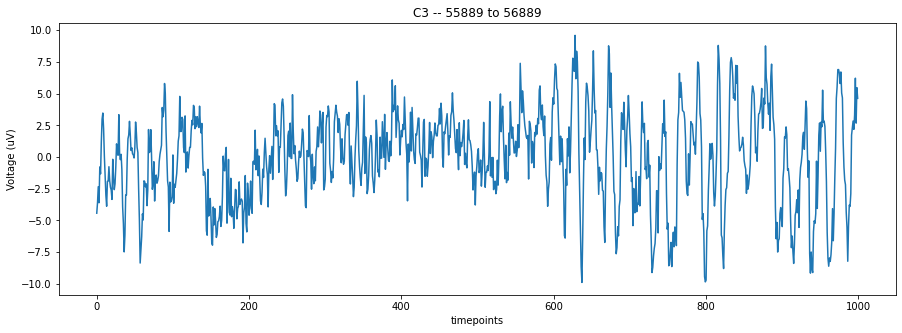

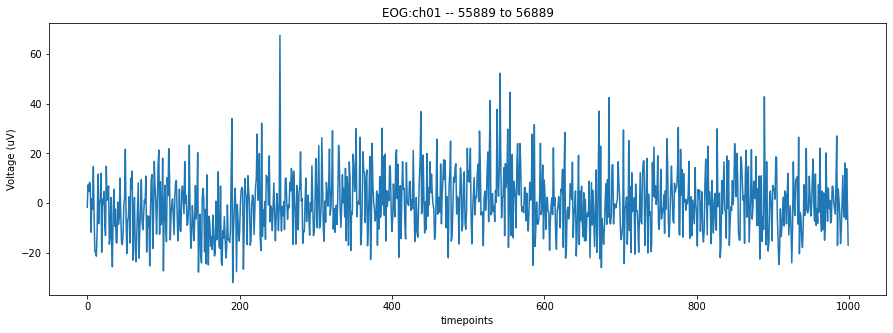

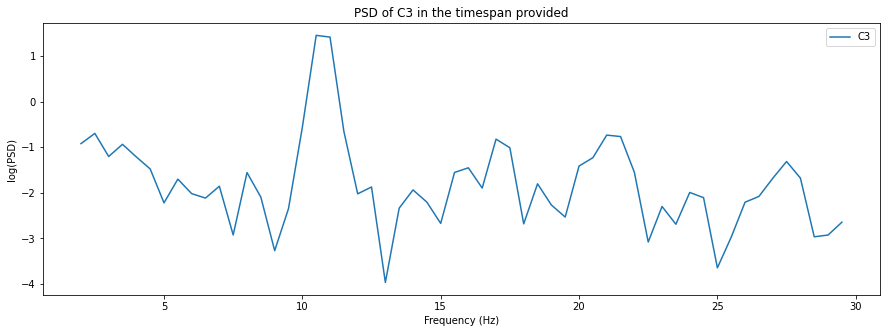

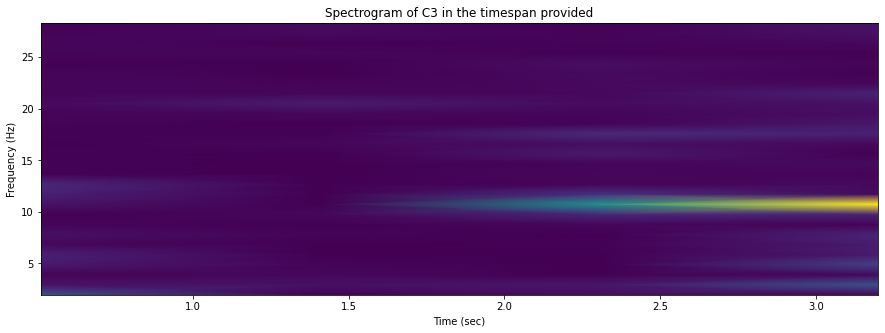

In [21]:
# Try adjust these variables to see different time ranges! 
# A single trial is 4 seconds or 1000 timpoints (4 ms per timepoint)
# Hint: refer to the Epoched data dataframe for the time of each trial
start_time_ms = 223556 # Start time in millis
start_time_timepoints = start_time_ms // 4 # Divide by 4 to get into timepoints
end_time_timepoints = start_time_timepoints + 1000 # Specify number of more timepoints we want past start

# Plot a single EEG channel
plt.figure(figsize=(15,5))
plt.plot(eeg_df['C3'].values[start_time_timepoints:end_time_timepoints])
plt.title("C3 -- " + str(start_time_timepoints) + " to " + str(end_time_timepoints))
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()

# Plot a single EOG channel
plt.figure(figsize=(15,5))
plt.plot(eeg_df['EOG:ch01'].values[start_time_timepoints:end_time_timepoints])
plt.title("EOG:ch01 -- " + str(start_time_timepoints) + " to " + str(end_time_timepoints))
plt.xlabel("timepoints")
plt.ylabel("Voltage (uV)")
plt.show()

# Plot the PSD of the single EEG channel
plt.figure(figsize=(15,5))
plotPSD_fromEEG(eeg_df['C3'].values[start_time_timepoints:end_time_timepoints], pre_cut_off_freq=2, post_cut_off_freq=30,label="C3")
plt.title("PSD of C3 in the timespan provided")
plt.legend()
plt.show()

# Plot the spectrogram of the single EEG channel
plt.figure(figsize=(15,5))
plotSpectrogram_fromEEG(eeg_df['C3'].values[start_time_timepoints:end_time_timepoints], pre_cut_off_freq=2, post_cut_off_freq=30)
plt.title("Spectrogram of C3 in the timespan provided")
plt.show()

## Epoch the data 
i.e. Group the time series it such that each row is a trial. We can see how each row contains 4 seconds of EEG or EOG data for each channel. 

In [22]:
# Try epoching at different lengths! (4000ms is default by experiment setup)
eeg_epoch_df = getEpochedDF(eeg_df, event_df, trial_duration_ms=4000) 

# Preview dataframe of trials
# start_time denotes the ms since the start of the recording when this trial or epoch started.
eeg_epoch_df.head(2)

,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."


In [23]:
# We've already epoched all the data into 4000ms trials for you in epoched_train.pkl and epoched_test.pkl :) 
# These are the epochs that will be used in accuracy evaluation
epoch_df_filename = Path("./data/epoched_train.pkl")
eeg_epoch_full_df = pd.read_pickle(epoch_df_filename)
eeg_epoch_full_df.head(2)

,patient_id,start_time,event_type,C3,Cz,C4,EOG:ch01,EOG:ch02,EOG:ch03
0,B0101T,223556.0,0,"[-3.6285954070344086, -2.337682154573892, -3.6...","[-2.920576791027695, -2.47501335164416, -2.548...","[5.502403295948728, 6.485084306095978, 6.68955...","[7.354848554207674, 4.699778744182498, 8.39246...","[5.676356145571068, 10.2235446707866, 16.08300...","[9.857328145265887, 4.303044174868391, 15.5336..."
1,B0101T,232996.0,1,"[2.9480430304417484, -0.05493247882810711, 0.3...","[4.437323567559321, 2.4872205691615163, 0.9674...","[1.3855191882200348, -0.4699778744182498, 0.44...","[-18.127718013275352, 18.188754100862134, -5.8...","[-14.373998626688028, 21.484702830548557, -6.2...","[-11.9325551232166, 20.202944991226055, -9.613..."


## Visualizing EEG, EOG, and PSD data of Epoched data
Note that EEG data has smaller amplitude than EOG data. This is because the electrical activity caused by eye movements is much greater than those of more purely the brain signals. You can still sometimes see eye artifacts in EEG data, but the affect is smaller due to the electrode's distance from the eyes. 

Note that the PSD for a single 4 second trial is incredibly noisy. Most EEG research requires that we average PSDs across trials to be able to see the "delta" "theta" "alpha" "beta" "gamma" bands we normally hear about. The y-axis of the PSD graph is logged because there is usually a lot more low frequency noise, so scaling the graph this way helps with the visual. 

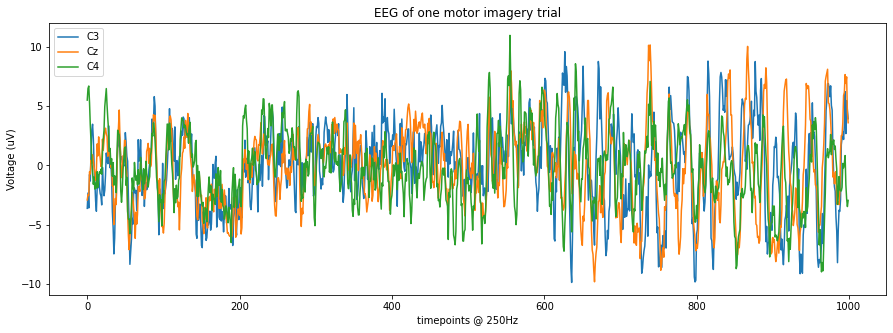

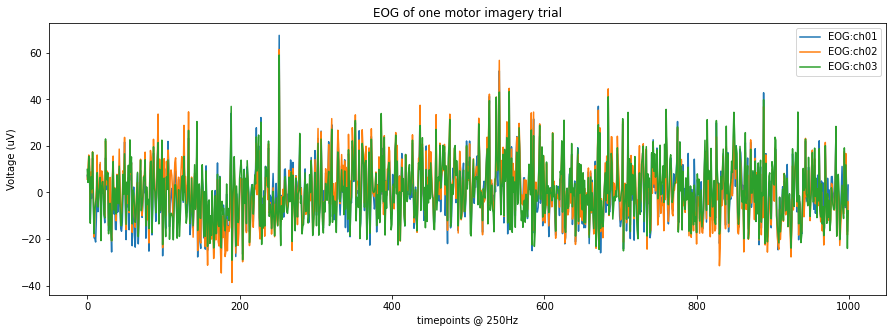

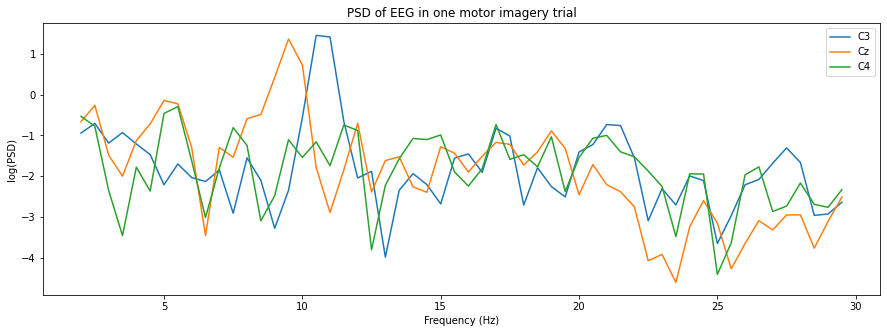

In [24]:
# Visualize EEG and PSD for one trial
# Try changing trial_num to view different trials!
trial_num = 0

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plt.plot(eeg_epoch_full_df[ch][trial_num], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EEG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eog_chans: 
    plt.plot(eeg_epoch_full_df[ch][trial_num], label=ch)
plt.ylabel("Voltage (uV)")
plt.xlabel("timepoints @ 250Hz")
plt.title("EOG of one motor imagery trial")
plt.legend() 
plt.show()

plt.figure(figsize=(15,5))
for ch in eeg_chans: 
    plotPSD_fromEEG(eeg_epoch_full_df[ch][trial_num], pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)
plt.title("PSD of EEG in one motor imagery trial")
plt.legend()
plt.show()


## Average PSD data in all training data
Let's average the PSDs in all the training data. We can see that there are more apparent differences between the different electrode's PSDs between the two classes. In particular, we can see how the relative PSDs of C3 and C4 channels vary between the two classes. In neuroscience literature, it is well documented that the alpha range power decreases on the opposite (i.e. contralateral) hemisphere when a hand or motor imagery on one side is performed. More on Mu Waves: https://en.wikipedia.org/wiki/Mu_wave. However, you may notice that the exact phenomena doesn't show up in all subjects. This is due to the noisy nature of EEG, brain folds, and subject performance. 

In [25]:
# Get PSD averages for each channel for each event type (0=left or 1=right)
psd_averages_by_type = {}

for event_type in event_types.keys(): 
    psds_only_one_type={}
    freqs_only_one_type={}
    for i, row in eeg_epoch_full_df[eeg_epoch_full_df["event_type"] == event_type].iterrows(): 
        for ch in eeg_chans: 
            if ch not in psds_only_one_type: 
                psds_only_one_type[ch] = list()
                freqs_only_one_type[ch] = list()
            f, p = getMeanFreqPSD(row[ch])
            psds_only_one_type[ch].append(p)
            freqs_only_one_type[ch].append(f)
    avg_psds_one_type = {}
    for ch in eeg_chans:
        psds_only_one_type[ch] = np.array(psds_only_one_type[ch])
        avg_psds_one_type[ch] = np.mean(psds_only_one_type[ch], axis=0)
    psd_averages_by_type[event_type] = dict(avg_psds_one_type)

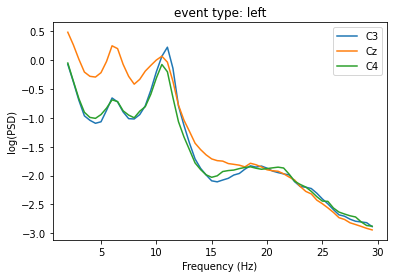

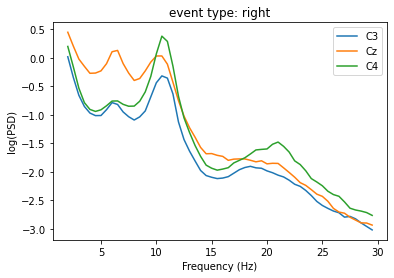

In [26]:
# View Average PSDs
for event_type in event_types.keys(): 
    for ch in eeg_chans[:]: 
        plotPSD(freqs_only_one_type[eeg_chans[0]][0], psd_averages_by_type[event_type][ch],pre_cut_off_freq=2, post_cut_off_freq=30, label=ch)

    plt.legend()
    plt.title("event type: " + event_types[event_type])
    plt.show()

## Some stats on the EEG data on a single session

### Mean voltage for 3 channels: 
As you can see, the mean voltage is very close to zero. This is because filtering the signal between 0.5Hz and 100Hz removes most of the slow fluctuations away from zero.

In [27]:
print('C3: ' + str(eeg_df['C3'].mean()) + " uV")
print('Cz: ' + str(eeg_df['Cz'].mean()) + " uV")
print('C4: ' + str(eeg_df['C4'].mean()) + " uV")

C3: -0.10846607963398974 uV
Cz: -0.11128156713907676 uV
C4: -0.11054305230804462 uV


### Standard deviation for 3 channels:
Standard deviation is not huge but still significantly larger than mean.

In [28]:
print('C3: ' + str(eeg_df['C3'].std()) + " uV")
print('Cz: ' + str(eeg_df['Cz'].std()) + " uV")
print('C4: ' + str(eeg_df['C4'].std()) + " uV")

C3: 5.604447873267008 uV
Cz: 4.856616019325033 uV
C4: 5.78067509572369 uV


### Range for 3 channels: 
Range is fairly large!

In [29]:
print('C3: ' + str(max(eeg_df['C3']) - min(eeg_df['C3'])) + " uV")
print('Cz: ' + str(max(eeg_df['Cz']) - min(eeg_df['Cz'])) + " uV")
print('C4: ' + str(max(eeg_df['C4']) - min(eeg_df['C4'])) + " uV")

C3: 155.5840390630961 uV
Cz: 121.8860151064317 uV
C4: 149.3614099336233 uV
